In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder


In [2]:
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersPerRouter", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [3]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [4]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [5]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [6]:
works = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 0]

temp = works['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
works['unproportionality_coeficient'] = temp[temp.columns[1]]/temp[temp.columns[0]]-1.0
works['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
works.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [7]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')

workc['unproportionality_coeficient'] = np.zeros([temp.shape[0], 1])
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [8]:
work = pd.concat([works, workc])

del works
del workc

work["BuffersNumber"] = work["BuffersPerRouter"]*work["RoutersNumber"]


Data ready

<Axes: >

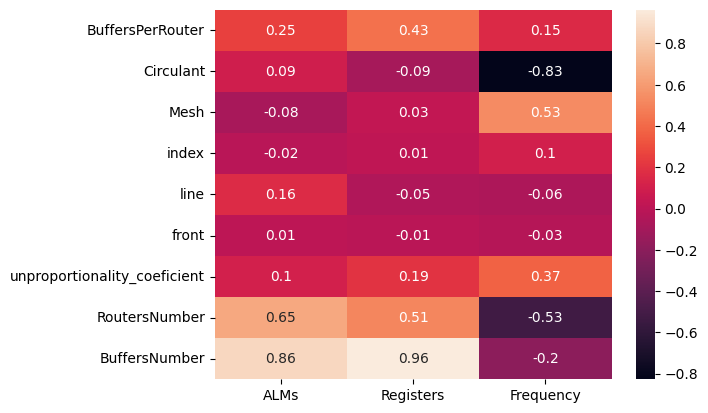

In [9]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "index", "line", "front", "BuffersNumber", "unproportionality_coeficient", "RoutersNumber", "BuffersPerRouter"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score


In [11]:
X = work.drop(["Registers", "ALMs", "Frequency"] ,axis=1)
y = work[["Registers", "ALMs", "Frequency"]]

xScaler = MinMaxScaler().fit(X)
rScaler = MinMaxScaler().fit(y[["Registers"]])
aScaler = MinMaxScaler().fit(y[["ALMs"]])
fScaler = MinMaxScaler().fit(y[["Frequency"]])

X = xScaler.transform(X)

y[["Registers"]] = rScaler.transform(y[["Registers"]])
y[["ALMs"]] = aScaler.transform(y[["ALMs"]])
y[["Frequency"]] = fScaler.transform(y[["Frequency"]])


/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/tmp/ipykernel_7051/2801834197.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[["Registers"]] = rScaler.transform(y[["Registers"]])
/tmp/ipykernel_7051/2801834197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [13]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [14]:
model = smf.ols(formula='Registers ~ Mesh + Circulant + index + line + front + BuffersNumber + BuffersPerRouter + RoutersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 3.349e+04
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:51:20   Log-Likelihood:                -43291.
No. Observations:                4429   AIC:                         8.660e+04
Df Residuals:                    4419   BIC:                         8.667e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [15]:
model = smf.ols(formula='ALMs ~ Mesh + Circulant + index + line + front + BuffersPerRouter  +  BuffersNumber + RoutersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     9099.
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:51:20   Log-Likelihood:                -44441.
No. Observations:                4429   AIC:                         8.890e+04
Df Residuals:                    4419   BIC:                         8.897e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [16]:
model = smf.ols(formula='Frequency ~ Mesh + Circulant + index + line + front + BuffersPerRouter + BuffersNumber + RoutersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4040.
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:51:20   Log-Likelihood:                -14598.
No. Observations:                4429   AIC:                         2.922e+04
Df Residuals:                    4419   BIC:                         2.928e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [17]:
lrR = LinearRegression()
lrR.fit(X_train, y_train["Registers"])

lrA = LinearRegression()
lrA.fit(X_train, y_train["ALMs"])

lrF = LinearRegression()
lrF.fit(X_train, y_train["Frequency"])

rP = lrR.predict(X_test)
aP = lrA.predict(X_test)
fP = lrF.predict(X_test)

print("Registers MSE:", root_mean_squared_error(y_test["Registers"], rP), 'R2:', r2_score(y_test["Registers"], rP), '\n', [abs(i) for i in lrR.coef_]/sum([abs(i) for i in lrR.coef_])*100)
print("ALMs MSE:", root_mean_squared_error(y_test["ALMs"], aP), 'R2:', r2_score(y_test["ALMs"], aP), '\n',[abs(i) for i in lrA.coef_]/sum([abs(i) for i in lrA.coef_])*100)
print("Frequency MSE:", root_mean_squared_error(y_test["Frequency"], fP), 'R2:', r2_score(y_test["Frequency"], fP), '\n', [abs(i) for i in lrF.coef_]/sum([abs(i) for i in lrF.coef_])*100)


Registers MSE: 0.022594367003209718 R2: 0.9853151898588822 
 [ 3.92843097  0.63329643  4.23551942  0.49125138  1.51394123  0.46514396
  3.73077483  5.26774112 79.73390068]
ALMs MSE: 0.0500286230136778 R2: 0.9496567331634262 
 [ 2.56401266  1.44574206  4.00916141  2.09076678  5.6341464   0.8725891
  0.92470212 13.15491075 69.30396873]
Frequency MSE: 0.05946431855588895 R2: 0.9070282366608398 
 [34.97514001 32.55681035  3.65423314  2.68619095  0.63529199  1.1209863
  1.50496689 18.06332725  4.80305312]


Сделаем поправку на ресурсы алгоритма и арбитера

In [18]:
arb2n = pd.read_csv('data/arbiter2n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb2n", "RegistersArb2n", "Frequency"], skiprows=1)
arb3n = pd.read_csv('data/arbiter3n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb3n", "RegistersArb3n", "Frequency"], skiprows=1)
arb4n = pd.read_csv('data/arbiter4n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb4n", "RegistersArb4n", "Frequency"], skiprows=1)
alg = pd.read_csv('data/algorithm.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsAlg", "RegistersAlg", "Frequency"], skiprows=1)
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersPerRouter", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [19]:
df = df.merge(arb2n[["ALMsArb2n", "RegistersArb2n", "DataLength"]], on=["DataLength"])
df = df.merge(arb3n[["ALMsArb3n", "RegistersArb3n", "DataLength"]], on=["DataLength"])
df = df.merge(arb4n[["ALMsArb4n", "RegistersArb4n", "DataLength"]], on=["DataLength"])
df = df.merge(alg[["ALMsAlg", "RegistersAlg", "DataLength", "Algorithm", "Topology"]], on=["DataLength", "Algorithm", "Topology"])


In [20]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [21]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [22]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [23]:
works = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 0]

temp = works['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
works["gen1"] = temp[temp.columns[0]]
works["gen2"] = temp[temp.columns[1]]
works['unproportionality_coeficient'] = temp[temp.columns[1]]/temp[temp.columns[0]]-1.0
works['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
works.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [24]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')
workc["gen1"] = temp[temp.columns[0]]
workc["gen2"] = temp[temp.columns[1]]
workc['unproportionality_coeficient'] = np.zeros([temp.shape[0], 1])
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

del temp


In [25]:
work = pd.concat([works, workc])

del works
del workc

work["BuffersNumber"] = work["BuffersPerRouter"]*work["RoutersNumber"]


In [26]:
work["ALMs"] -= work["ALMsAlg"]*work["RoutersNumber"]
work["Registers"] -= work["RegistersAlg"]*work["RoutersNumber"]

work[work["Mesh"] == 0]["ALMs"] -= - work[work["Mesh"] == 0]["ALMsArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]
work[work["Mesh"] == 0]["Registers"] -= work[work["Mesh"] == 0]["RegistersArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]

work[work["Mesh"] == 1]["ALMs"] -= - work[work["Mesh"] == 1]["ALMsArb4n"]*((work["gen1"]-1)*(work["gen2"]-1))
work[work["Mesh"] == 1]["ALMs"] -= - work[work["Mesh"] == 1]["ALMsArb3n"]*((work["gen1"] + work["gen2"])*2 - 4 - 4)
work[work["Mesh"] == 1]["ALMs"] -= - work[work["Mesh"] == 1]["ALMsArb2n"]*4

work[work["Mesh"] == 1]["Registers"] -= - work[work["Mesh"] == 1]["RegistersArb4n"]*(work[work["Mesh"] == 1]["RoutersNumber"] - (work[work["Mesh"] == 1]["gen1"] + work[work["Mesh"] == 1]["gen2"])*2 + 4)
work[work["Mesh"] == 1]["Registers"] -= - work[work["Mesh"] == 1]["RegistersArb3n"]*((work[work["Mesh"] == 1]["gen1"] + work[work["Mesh"] == 1]["gen2"]) - 4 - 4)
work[work["Mesh"] == 1]["Registers"] -= - work[work["Mesh"] == 1]["RegistersArb2n"]*4

work.drop(columns=["gen1", "gen2", "ALMsArb2n", "RegistersArb2n", "ALMsArb3n", "RegistersArb3n", "ALMsArb4n", "RegistersArb4n", "ALMsAlg", "RegistersAlg"], inplace=True)

/tmp/ipykernel_7051/2958870765.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  work[work["Mesh"] == 0]["ALMs"] -= - work[work["Mesh"] == 0]["ALMsArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]
/tmp/ipykernel_7051/2958870765.py:4: Settin

Удаление закончено

<Axes: >

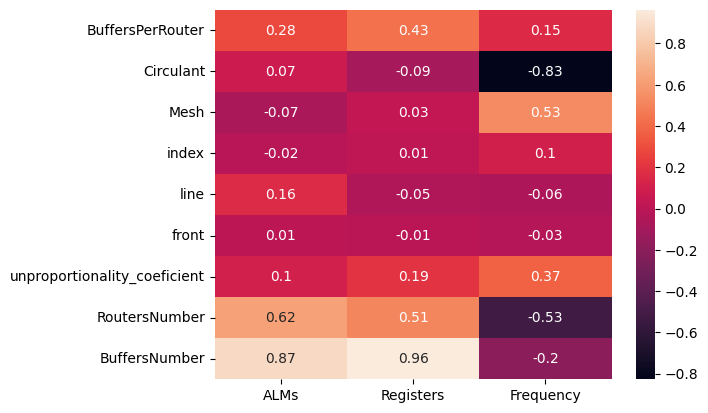

In [27]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "index", "line", "front", "BuffersNumber", "unproportionality_coeficient", "RoutersNumber", "BuffersPerRouter"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [28]:
X = work.drop(["Registers", "ALMs", "Frequency"] ,axis=1)
y = work[["Registers", "ALMs", "Frequency"]]

xScaler = MinMaxScaler().fit(X)
rScaler = MinMaxScaler().fit(y[["Registers"]])
aScaler = MinMaxScaler().fit(y[["ALMs"]])
fScaler = MinMaxScaler().fit(y[["Frequency"]])

X = xScaler.transform(X)

y[["Registers"]] = rScaler.transform(y[["Registers"]])
y[["ALMs"]] = aScaler.transform(y[["ALMs"]])
y[["Frequency"]] = fScaler.transform(y[["Frequency"]])


/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/elgrush/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/tmp/ipykernel_7051/2801834197.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[["Registers"]] = rScaler.transform(y[["Registers"]])
/tmp/ipykernel_7051/2801834197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [30]:
model = smf.ols(formula='Registers ~ Mesh + Circulant + index + line + front + BuffersNumber + BuffersPerRouter + RoutersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 3.349e+04
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:51:22   Log-Likelihood:                -43291.
No. Observations:                4429   AIC:                         8.660e+04
Df Residuals:                    4419   BIC:                         8.667e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [31]:
model = smf.ols(formula='ALMs ~ Mesh + Circulant + index + line + front + BuffersPerRouter  +  BuffersNumber + RoutersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     8668.
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:51:22   Log-Likelihood:                -44426.
No. Observations:                4429   AIC:                         8.887e+04
Df Residuals:                    4419   BIC:                         8.894e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [32]:
model = smf.ols(formula='Frequency ~ Mesh + Circulant + index + line + front + BuffersPerRouter + BuffersNumber + RoutersNumber + unproportionality_coeficient', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4040.
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:51:22   Log-Likelihood:                -14598.
No. Observations:                4429   AIC:                         2.922e+04
Df Residuals:                    4419   BIC:                         2.928e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [33]:
lrR = LinearRegression()
lrR.fit(X_train, y_train["Registers"])

lrA = LinearRegression()
lrA.fit(X_train, y_train["ALMs"])

lrF = LinearRegression()
lrF.fit(X_train, y_train["Frequency"])

rP = lrR.predict(X_test)
aP = lrA.predict(X_test)
fP = lrF.predict(X_test)

print("Registers MSE:", root_mean_squared_error(y_test["Registers"], rP), 'R2:', r2_score(y_test["Registers"], rP), '\n', [abs(i) for i in lrR.coef_]/sum([abs(i) for i in lrR.coef_])*100)
print("ALMs MSE:", root_mean_squared_error(y_test["ALMs"], aP), 'R2:', r2_score(y_test["ALMs"], aP), '\n',[abs(i) for i in lrA.coef_]/sum([abs(i) for i in lrA.coef_])*100)
print("Frequency MSE:", root_mean_squared_error(y_test["Frequency"], fP), 'R2:', r2_score(y_test["Frequency"], fP), '\n', [abs(i) for i in lrF.coef_]/sum([abs(i) for i in lrF.coef_])*100)


Registers MSE: 0.022594367003209718 R2: 0.9853151898588822 
 [ 3.92843097  0.63329643  4.23551942  0.49125138  1.51394123  0.46514396
  3.73077483  5.26774112 79.73390068]
ALMs MSE: 0.05068953395308331 R2: 0.9472958836590898 
 [ 2.76659702  1.29628537  4.07721736  2.12649098  5.7287463   0.88563116
  1.00485566 11.44843244 70.66574372]
Frequency MSE: 0.05946431855588895 R2: 0.9070282366608398 
 [34.97514001 32.55681035  3.65423314  2.68619095  0.63529199  1.1209863
  1.50496689 18.06332725  4.80305312]
